In [12]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [24]:
# Configuración general
folder_path = r"C:\Users\Ibon\PycharmProjects\Microgrid\TrainTestSplit"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Función para extraer la ubicación del nombre del archivo
def extract_location(filename):
    return filename.split('_')[0]  # Ajustar según la estructura real de los nombres

def extract_csv_id(filename):
    return filename.split('_')[1]  # O la parte que identifique el CSV

# Cargar y procesar datos
df_list = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, parse_dates=["Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss"])
    
    # Extraer ubicación y añadir columna
    df['location'] = extract_location(file)
    df['csv_id'] = df['location'] + "_" + extract_csv_id(file)

    
    # Muestreo estratificado (aumentar el % si es necesario)
    sample_df = df.sample(frac=0.2, random_state=42)  # Aumentado a 20%
    df_list.append(sample_df)
    

df_merged = pd.concat(df_list, ignore_index=True)
df_merged = df_merged.drop(columns='Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss')

In [25]:
# Procesamiento separado para características numéricas y categóricas
numerical_cols = df_merged.columns.drop(['Pmp (W)', 'location']).tolist()
categorical_col = ['location']

# Preprocesamiento
X_num = df_merged[numerical_cols].values.astype(np.float32)
X_cat = df_merged[categorical_col].values

# Codificar categorías
ohe = OneHotEncoder(sparse_output=False)
X_cat_encoded = ohe.fit_transform(X_cat).astype(np.float32)

# Escalar características numéricas
scaler_num = StandardScaler()
X_num_scaled = scaler_num.fit_transform(X_num)

# Combinar características
X = np.hstack([X_num_scaled, X_cat_encoded])
y = df_merged['Pmp (W)'].values.astype(np.float32)

# Split estratificado por ubicación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=df_merged['csv_id']  # Estratifica por la combinación ubicación y CSV
)

# Convertir a tensores
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train).unsqueeze(1)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test).unsqueeze(1)

ValueError: could not convert string to float: 'Cocoa_aSiMicro03036.csv'

In [15]:
# Modelo mejorado con características categóricas
class EnhancedDNN(nn.Module):
    def __init__(self, input_dim, num_locations):
        super(EnhancedDNN, self).__init__()
        
        # Capa de embeddings para ubicación (alternativa a one-hot)
        self.location_embedding = nn.Embedding(num_locations, 8)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim - num_locations + 8, 512),  # Ajustar dimensión
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            
            nn.Linear(64, 1)
        )
        
        self.num_locations = num_locations

    def forward(self, x):
        # Separar características numéricas y categóricas
        num_features = x[:, :-self.num_locations]
        cat_features = torch.argmax(x[:, -self.num_locations:], dim=1)
        
        # Embedding de ubicaciones
        embedded = self.location_embedding(cat_features)
        
        # Combinar características
        combined = torch.cat([num_features, embedded], dim=1)
        return self.model(combined)

# Configuración del modelo
num_locations = X_cat_encoded.shape[1]
input_dim = X.shape[1]
model = EnhancedDNN(input_dim, num_locations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EnhancedDNN(
  (location_embedding): Embedding(3, 8)
  (model): Sequential(
    (0): Linear(in_features=17, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): ReLU()
    (14): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [16]:
# Optimización y entrenamiento mejorados
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.3)
criterion = nn.HuberLoss()  # Más robusto que MSE
# Entrenamiento con early stopping
epochs = 200
best_loss = np.inf
patience = 15
counter = 0
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    
    avg_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    scheduler.step(avg_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    
    # Early stopping mejorado
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
        torch.save(model.state_dict(), "best_model_multicsv.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break


Epoch [1/200], Loss: 16.8828
Epoch [2/200], Loss: 13.2606
Epoch [3/200], Loss: 13.1715
Epoch [4/200], Loss: 13.1259
Epoch [5/200], Loss: 13.1060
Epoch [6/200], Loss: 13.0989
Epoch [7/200], Loss: 13.0759
Epoch [8/200], Loss: 13.0770
Epoch [9/200], Loss: 13.0655
Epoch [10/200], Loss: 13.0471
Epoch [11/200], Loss: 13.0532
Epoch [12/200], Loss: 13.0387
Epoch [13/200], Loss: 13.0191
Epoch [14/200], Loss: 13.0132
Epoch [15/200], Loss: 12.9956
Epoch [16/200], Loss: 13.0132
Epoch [17/200], Loss: 13.0116
Epoch [18/200], Loss: 12.9938
Epoch [19/200], Loss: 13.0122
Epoch [20/200], Loss: 12.9903
Epoch [21/200], Loss: 13.0011
Epoch [22/200], Loss: 12.9812
Epoch [23/200], Loss: 12.9853
Epoch [24/200], Loss: 12.9650
Epoch [25/200], Loss: 12.9815
Epoch [26/200], Loss: 12.9759
Epoch [27/200], Loss: 12.9616
Epoch [28/200], Loss: 12.9592
Epoch [29/200], Loss: 12.9617
Epoch [30/200], Loss: 12.9572
Epoch [31/200], Loss: 12.9610
Epoch [32/200], Loss: 12.9671
Epoch [33/200], Loss: 12.9663
Epoch [34/200], Los

C:\Users\Ibon\AppData\Local\Temp\ipykernel_24328\1474292418.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_multicsv.pth"))



📊 Test MSE: 712.0853
📏 Test MAE: 13.2624
📈 Test R2: 0.5110


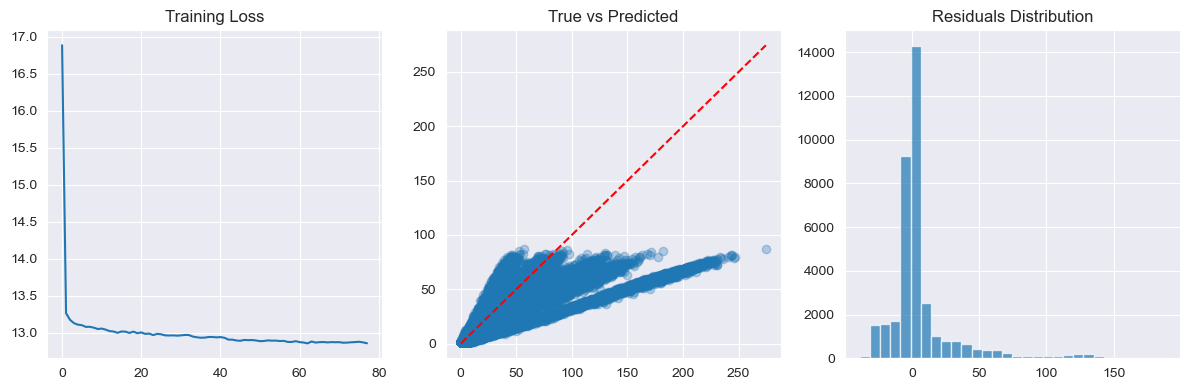

In [18]:
# Evaluación
model.load_state_dict(torch.load("best_model_multicsv.pth"))
model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor.to(device)).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

# Métricas mejoradas
mse = mean_squared_error(y_test_np, y_pred)
mae = mean_absolute_error(y_test_np, y_pred)
r2 = r2_score(y_test_np, y_pred)

print(f"\n📊 Test MSE: {mse:.4f}")
print(f"📏 Test MAE: {mae:.4f}")
print(f"📈 Test R2: {r2:.4f}")

# Gráficas adicionales de análisis
residuals = y_test_np - y_pred

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(train_losses)
plt.title('Training Loss')

plt.subplot(132)
plt.scatter(y_test_np, y_pred, alpha=0.3)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')
plt.title('True vs Predicted')

plt.subplot(133)
plt.hist(residuals, bins=30, alpha=0.7)
plt.title('Residuals Distribution')

plt.tight_layout()
plt.show()